## The model

Let's consider the Black and Scholes equation (PDE)

$\frac{\partial V}{\partial t} + r S \frac{\partial V}{\partial S} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} - r V = 0,$

where:

+ $V$ is the price of the option as a function of the underlying asset price $S$ and time $t$,
+ $S$ is the current price of the underlying asset,
+ $t$ is the current time,
+ $\sigma$ is the volatility of the underlying asset,
+ $r$ is the risk-free interest rate.

Moreover, consider a European call option, i.e. the boundary condition at expiration ($t=T$) is:

$V(S,T)= max⁡[S(T)−K,0],$

where $K$ is the strike price.

## Crank Nicholson Finite Differences scheme

Let's consider the following discretizations of the domain:

+ for $t \in [0, T],$ consider $m+1$ time points, with timestep $\Delta t$,
+ for $S \in [0, S_{max}],$ consider $n + 1$ discretization points, with step $\Delta S.$

Let $i \in [0,\; m-1]$ and $j \in [1,\; n-1].$ For our finite difference scheme, consider:

$V(j\Delta S,\; (i + \frac{1}{2})\Delta t) \approx \frac{1}{2}(V_j^i + V_j^{i+1}),$

$\frac{\partial V}{\partial S}(j\Delta S,\; (i + \frac{1}{2})\Delta t) \approx \frac{1}{2}(\frac{V_{j+1}^i \;-\; V_{j -1}^i}{2\Delta S} + \frac{V_{j+1}^{i+1} \;-\; V_{j -1}^{i+1}}{2\Delta S}),$

$\frac{\partial^2 V}{\partial S^2}(j\Delta S,\; (i + \frac{1}{2})\Delta t) \approx \frac{1}{2}(\frac{V_{j+1}^i \;-\; 2V_{j}^i \; + \; V_{j-1}^i}{(\Delta S)^2} + \frac{V_{j+1}^{i+1} \;-\; 2V_{j}^{i+1} \; + \; V_{j-1}^{i+1}}{(\Delta S)^2}),$

where $V_j^i = V(j\Delta S,\; i\Delta t).$

The above approximations are given by the averages of the centered difference operators at the $i$-th and $(i+1)$-th time steps. 

For the time derivative, consider the centered difference scheme

$\frac{\partial V}{\partial t}(j\Delta S,\; (i + \frac{1}{2})\Delta t) \approx \frac{V_j^{i +1} \;-\; V_j^i}{\Delta t}.$

So, substituting in the PDE our approximations we get:

$\frac{V_j^{i +1} \;-\; V_j^i}{\Delta t} + r j\Delta S \frac{1}{4}(\frac{V_{j+1}^i \;-\; V_{j -1}^i}{\Delta S} + \frac{V_{j+1}^{i+1} \;-\; V_{j -1}^{i+1}}{\Delta S}) + \frac{1}{4}\sigma^2 j^2\Delta S^2 (\frac{V_{j+1}^i \;-\; 2V_{j}^i \; + \; V_{j-1}^i}{(\Delta S)^2} + \frac{V_{j+1}^{i+1} \;-\; 2V_{j}^{i+1} \; + \; V_{j-1}^{i+1}}{(\Delta S)^2}) - \frac{r}{2}(V_j^i + V_j^{i+1}) = 0$

This is equivalent to:

$V_j^{i +1} \;-\; V_j^i +\Delta t [ r j \frac{1}{4}(V_{j+1}^i \;-\; V_{j -1}^i + V_{j+1}^{i+1} \;-\; V_{j -1}^{i+1}) + \frac{1}{4}\sigma^2 j^2 (V_{j+1}^i \;-\; 2V_{j}^i \; + \; V_{j-1}^i + V_{j+1}^{i+1} \;-\; 2V_{j}^{i+1} \; + \; V_{j-1}^{i+1}) - \frac{r}{2}(V_j^i + V_j^{i+1})] = 0$


Rearraging the terms, we get:

$[-\frac{\Delta t}{4}(-rj + \sigma^2 j^2)]V_{j-1}^{i} + [1 +\frac{\Delta t}{2}(\sigma^2 j^2 + r)]V_{j}^{i} + [-\frac{\Delta t}{4}(rj + \sigma^2 j^2 )]V_{j+1}^{i} = [\frac{\Delta t}{4}(-rj + \sigma^2 j^2)]V_{j-1}^{i+1} + [1 - \frac{\Delta t}{2}(\sigma^2 j^2 + r)]V_{j}^{i+1} + [\frac{\Delta t}{4}(rj + \sigma^2 j^2)]V_{j+1}^{i+1}
$

or equivalently:

$a_jV_{j-1}^{i} + (1 + b_j)V_{j}^{i} + c_jV_{j+1}^{i} = -a_jV_{j-1}^{i+1} + (1 - b_j)V_{j}^{i+1} - c_jV_{j+1}^{i+1} = r_j.$

As we can observe, the associated linear system is tridiagonal, so we can use Thomas algorithm to compute the solution efficiently.

Moreover, we will solve the system backward in time.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy.stats import norm
from matplotlib import cm 
from matplotlib.ticker import LinearLocator 

In [2]:
# Activate interaction with the 3d figures
%matplotlib notebook

In [3]:
def thomas(a,b,c,r):
    """ 
    Compute solution to Tx = r, where T = tridiag(a,b,c)
    using Thomas algorithm.
    """
    n = len(b)
    for j in range(1,n):
        a[j] /= b[j-1]
        b[j] -= a[j] * c[j-1]
        r[j] -= a[j] * r[j-1]
    r[-1] /= b[-1]
    for j in reversed(range(n-1)):
        r[j] = (r[j] - c[j] * r[j+1]) / b[j]

In [4]:
def B_S_Finite_Differences(r = 0.05, sigma = 0.2, K = 100, S_max = 200, delta_S = 1, T = 1, delta_t = 0.05):
    """
    Compute the solution of the B&S model using the Crank-Nicholson method.
    
    Parameters:
    -) r: risk-free interest rate
    -) sigma: volatility of the asset
    -) K: strike price
    -) S_max: the maximum price of the underlying asset
    -) delta_S: discretization step in price
    -) T: expiration time
    -) delta_t: discretization step in time
    """
    
    m = int(T/delta_t) # number of intervals in time
    n = int(S_max/delta_S) # number of intervals in price
    #print(m)
    #print(n)
     
    # As left boundary we have V(0, t) = 0 for all t in [0, T] (Low stock price)
    # As right boundary, we have that V(S_max, t) = S_max - K*exp(-r*(T-t)) for all t in [0, T] (High stock price)
    # Moreover, V(S, T) = max[S(T) - K, 0] ==> V_(n+1)^(m+1) = max[S(T) - K, 0]
    Sol = np.empty((m+1,n+1)) # initialize the matrix that contains the solution (evolving in time changing rows)
    Sol[:] = np.nan
    Sol[:,0] = np.zeros(m+1) # left condition
    Sol[:,-1] = S_max - K*np.exp(-r*(T-np.linspace(0, T, num=m+1))) # right condition
    Sol[-1,:] = np.maximum(np.linspace(0, S_max, num=n+1) - K, np.zeros(n+1)) # end condition
    
    tic = time()
    for q in reversed(range(m)): # backward in time
        # Let's create the diagonals of the tridiagonal matrix
        a = -0.25*delta_t*(-r*np.arange(0,n+1) + (sigma**2)*np.arange(0,n+1)**2) # lower diagonal
        b = 0.5*delta_t*((sigma**2)*np.arange(0,n+1)**2  + r) # diagonal
        c = -0.25*delta_t*(r*np.arange(0,n+1) + (sigma**2)*np.arange(0,n+1)**2) # upper diagonal
        # Right-handside vector
        rest = -a[1:-1]*Sol[q+1,0:-2] + (1 - b[1:-1])*Sol[q+1,1:-1] - c[1:-1]*Sol[q+1,2:]
        rest[0] -= a[1]*Sol[q,0] # corrections for adjusted boundary conditions
        rest[-1] -= c[-2]*Sol[q,-1]
        # Solve the system
        thomas(a[1:-1], (1+b[1:-1]), c[1:-1], rest)
        Sol[q,1:-1] = rest # save the solution in Sol
        
    el = time()-tic
    print(f"Time elapsed: {el} seconds")
    return Sol

Let's run it!

In [5]:
# Fix the parameters
S_max = 200
delta_S = 1
K = 50
T = 1
delta_t = 0.05
r = 0.25
sigma = 0.1

m = int(T/delta_t)
n = int(S_max/delta_S)

In [6]:
V_cn = B_S_Finite_Differences(r, sigma, K, S_max, delta_S, T, delta_t)

Time elapsed: 0.015065193176269531 seconds


In [7]:
S_disc = np.linspace(0, S_max, num=n+1) # discretized price space
T_disc = np.linspace(0, T, num=m+1) # discretized time space

<IPython.core.display.Javascript object>


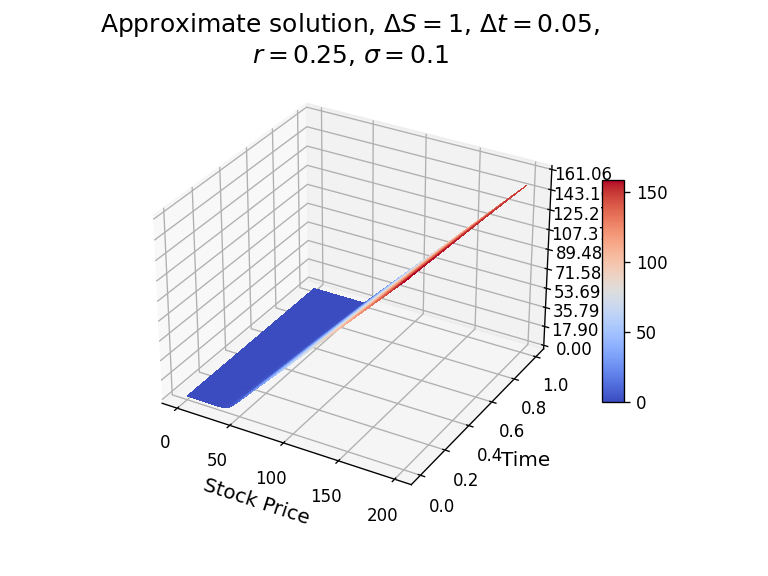

In [8]:
# Plot of the computed solution
S_mesh,T_mesh = np.meshgrid(S_disc,T_disc) # for 3d plot we need a meshgrid
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(S_mesh, T_mesh, V_cn, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
plt.title(r'Approximate solution, $\Delta S =$' +str(delta_S)+ ', $\Delta t =$'
          +str(delta_t)+ ', $r =$' +str(r)+', $\sigma =$' +str(sigma),      
          fontsize="15", wrap=True)
plt.xlabel(r'Stock Price', fontsize="12")
plt.ylabel(r'Time', fontsize="12")  
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

In [9]:
plt.ioff()

## The exact solution

We have that the price of the option with expiration $T$, evaluated at time $t$ is

$V(S,t)=S_{t}N(d_{1})-Ke^{-r\;(T-t)}N(d_{2}),$

where:

+ $S_{t}$ is the price of the underlying asset at time $t$,
+ $N(⋅)$ is the cumulative distribution function of the standard normal distribution, that is $N(d) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{d} e^{-\frac{x^2}{2}} \, dx,$
+ $d_1 = \frac{\log(\;\frac{S_t}{K}\;) \;+ \;(r \;+\; \frac{\sigma^2}{2}) (T - t)}{\sigma \sqrt{T - t}},$
+ $d_2 = d_1 - \sigma \sqrt{T-t}.$

In [10]:
# Let's compute the exact solution
def exact_solution(r = 0.05, sigma = 0.2, K = 100, S_max = 200, delta_S = 1, T = 1, delta_t = 0.05):
    """
    Compute the exact solution of the B&S model.
    
    Parameters:
    -) r: risk-free interest rate
    -) sigma: volatility of the asset
    -) K: strike price
    -) S_max: the maximum price of the underlying asset
    -) delta_S: discretization step in price
    -) T: expiration time
    -) delta_t: discretization step in time
    """
    
    m = int(T/delta_t) # number of intervals in time
    n = int(S_max/delta_S) # number of intervals in price
    S_disc = np.linspace(0, S_max, num=n+1) # discretized price space
    T_disc = np.linspace(0, T, num=m+1) # discretized time space
    
    V_exact = np.empty((m+1,n+1)) # initialize the exact solution
    V_exact[:] = np.nan
    V_exact[:,0] = np.zeros(m+1) # left condition
    V_exact[:,-1] = S_max - K*np.exp(-r*(T-T_disc)) # right condition
    V_exact[-1,:] = np.maximum(S_disc - K, np.zeros(n+1)) # end condition
    for q in range(0, m): # iterate through time
        d1_vect = (np.log(S_disc[1:-1]/K) + 
                  (r + 0.5*(sigma)**2)*(T - T_disc[q]))/(sigma*np.sqrt(T - T_disc[q])) # compute d1
        d2_vect = d1_vect - sigma*np.sqrt(T - T_disc[q]) # compute d2
        Nd1 = norm.cdf(d1_vect) # cumulative distribution function of d1
        Nd2 = norm.cdf(d2_vect) # cumulative distribution function of d2
        V_exact[q,1:-1] = S_disc[1:-1]*Nd1 - K*np.exp(-r*(T - T_disc[q]))*Nd2
        
    return V_exact    

In [11]:
V_exact = exact_solution(r, sigma, K, S_max, delta_S, T, delta_t)

<IPython.core.display.Javascript object>


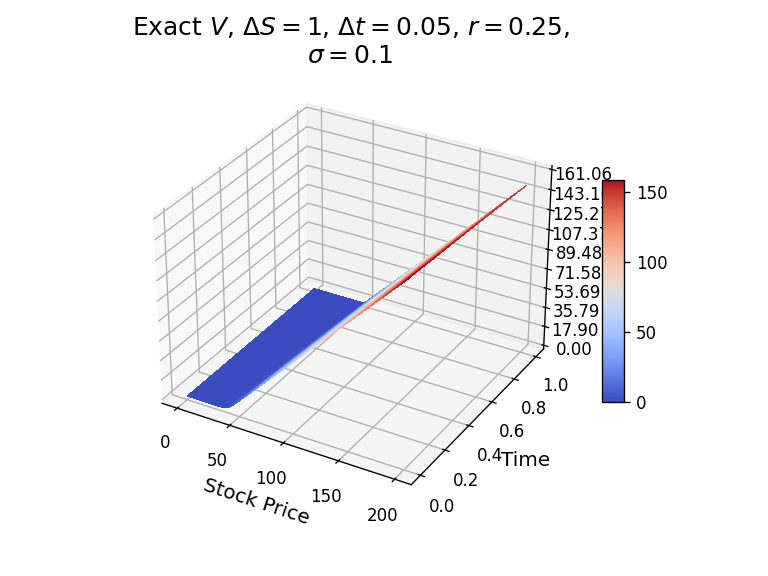

In [12]:
# Plot of the exact solution
S_mesh,T_mesh = np.meshgrid(S_disc,T_disc)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(S_mesh, T_mesh, V_exact, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
plt.title(r'Exact $V$, $\Delta S =$' +str(delta_S)+ ', $\Delta t =$'
          +str(delta_t)+ ', $r =$' +str(r)+', $\sigma =$' +str(sigma),      
          fontsize="15", wrap=True)
plt.xlabel(r'Stock Price', fontsize="12")
plt.ylabel(r'Time', fontsize="12")  
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

In [13]:
plt.ioff()

## The errors

In [14]:
# Fix some parameters
S_max = 500
K = 200
T = 1
r = 0.1
sigma = 0.2

Fix $\Delta S$ and plot the relative error at initial time against $\Delta t.$

In [15]:
delta_S = 0.25 # fixed
delta_t = 0.1
n_iter = 6 # number of iterations
m_arr = np.empty(n_iter)
m_arr[:] = np.nan
rel_L2_error_fixed_S = np.empty(n_iter)
rel_L2_error_fixed_S[:] = np.nan
for i in range(0, n_iter):
    print(f"Iteration for delta_t = {delta_t}")
    m = int(T/delta_t)
    #print(m)
    m_arr[i] = m
    V_num = B_S_Finite_Differences(r, sigma, K, S_max, delta_S, T, delta_t)
    V_exact = exact_solution(r, sigma, K, S_max, delta_S, T, delta_t)
    rel_L2_error_fixed_S[i] = np.linalg.norm(V_num[0,:] - V_exact[0,:]) / np.linalg.norm(V_exact[0,:])
    #print(rel_L2_error_fixed_S[i])
    delta_t /= 2

Iteration for delta_t = 0.1
Time elapsed: 0.06265473365783691 seconds
Iteration for delta_t = 0.05
Time elapsed: 0.0626535415649414 seconds
Iteration for delta_t = 0.025
Time elapsed: 0.11861348152160645 seconds
Iteration for delta_t = 0.0125
Time elapsed: 0.22790908813476562 seconds
Iteration for delta_t = 0.00625
Time elapsed: 0.4709460735321045 seconds
Iteration for delta_t = 0.003125
Time elapsed: 0.9275901317596436 seconds


In [16]:
%matplotlib inline

In [17]:
plt.rcParams['figure.figsize'] = [15, 8] # adjust size of plots

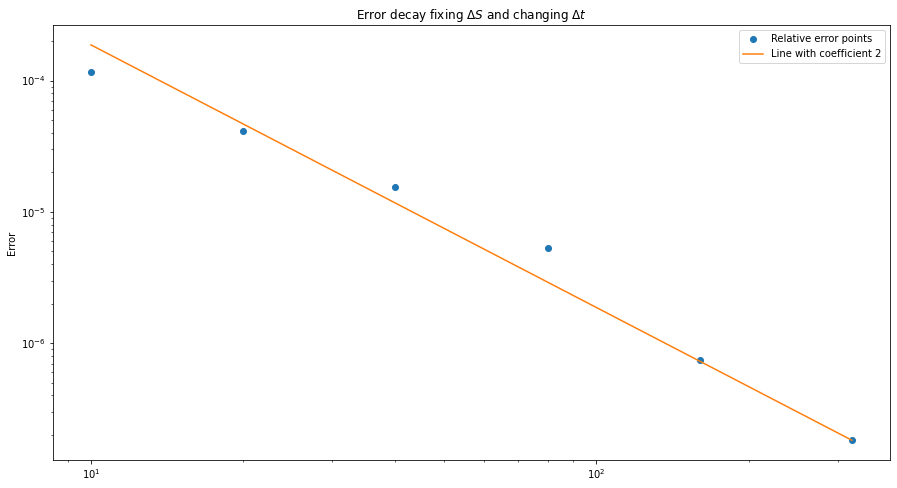

In [18]:
plt.loglog(m_arr, rel_L2_error_fixed_S, 'o', label="Relative error points")
plt.loglog(m_arr, rel_L2_error_fixed_S[-1]*(m_arr/m_arr[-1])**(-2), label="Line with coefficient 2")
plt.ylabel("Error")
plt.title(r'Error decay fixing $\Delta S$ and changing $\Delta t$')
plt.legend()
plt.show()

Fix $\Delta t$ and plot the relative error at initial time against $\Delta S.$

In [19]:
delta_t = 0.05 # fixed
delta_S = 0.2
n_iter = 6 # number of iterations
n_arr = np.empty(n_iter)
n_arr[:] = np.nan
rel_L2_error_fixed_t = np.empty(n_iter)
rel_L2_error_fixed_t[:] = np.nan
for i in range(0, n_iter):
    print(f"Iteration for delta_S = {delta_S}")
    n = int(S_max/delta_S)
    #print(n)
    n_arr[i] = n
    V_num = B_S_Finite_Differences(r, sigma, K, S_max, delta_S, T, delta_t)
    V_exact = exact_solution(r, sigma, K, S_max, delta_S, T, delta_t)
    rel_L2_error_fixed_t[i] = np.linalg.norm(V_num[0,:] - V_exact[0,:]) / np.linalg.norm(V_exact[0,:])
    #print(rel_L2_error_fixed_t[i])
    delta_S /= 2

Iteration for delta_S = 0.2
Time elapsed: 0.08995413780212402 seconds
Iteration for delta_S = 0.1
Time elapsed: 0.15224218368530273 seconds
Iteration for delta_S = 0.05
Time elapsed: 0.3092782497406006 seconds
Iteration for delta_S = 0.025
Time elapsed: 0.7100012302398682 seconds
Iteration for delta_S = 0.0125
Time elapsed: 1.266087532043457 seconds
Iteration for delta_S = 0.00625
Time elapsed: 2.657822608947754 seconds


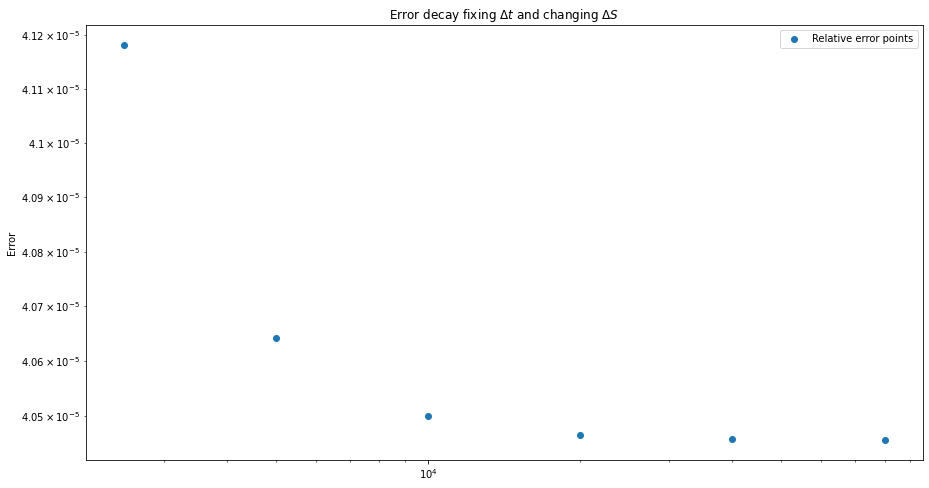

In [20]:
plt.loglog(n_arr, rel_L2_error_fixed_t, 'o', label="Relative error points")
#plt.loglog(n_arr, rel_L2_error_fixed_t[-1]*(n_arr/n_arr[-1])**(-1), label="Line with coefficient 1")
plt.ylabel("Error")
plt.title(r'Error decay fixing $\Delta t$ and changing $\Delta S$')
plt.legend()
plt.show()